In [1]:
import torch
import torch.nn as nn

class Unit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unit, self).__init__()

        self.conv = nn.Conv1d(in_channels=in_channels, kernel_size=3, out_channels=out_channels)
        self.bn = nn.BatchNorm1d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class SimpleNet(nn.Module):
    def __init__(self,num_classes=2):
        super(SimpleNet,self).__init__()
        
        self.unit1 = Unit(in_channels=20,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.avgpool1 = nn.AvgPool1d(kernel_size=16)
        self.avgpool2 = nn.AvgPool1d(kernel_size=4)
        
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, 
                                 self.pool3, 
                                 self.avgpool1, self.avgpool2)

        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)
        return output
    

In [2]:
trainAcc = []
trainLoss = []
testAcc = []
trainRecall = []
trainPre = []
testRecall = []
trainPre = []
epoches = 200

In [3]:
def adjust_learning_rate(epoch):
    lr = 0.00001
    if epoch > 180:
        lr = lr / 100000
    elif epoch > 150:
        lr = lr / 10000
    elif epoch > 120:
        lr = lr / 1000
    elif epoch > 90:
        lr = lr / 100
    elif epoch > 60:
        lr = lr / 10
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


In [4]:
def test(test_loader):
    model.eval()
    test_acc = 0.0
    for i, (data, labels) in enumerate(test_loader):

        data = Variable(data.cuda())
        labels = Variable(labels.cuda())
        outputs = model(data)
        
        _, prediction = torch.max(outputs.data, 1)
        result = torch.sum(prediction == labels.data).item() / len(labels)
        test_acc += result
        test_recall += torch.sum(prediction == labels.data and labels.data == [1]*labels.data.size(0)).item() / len(labels.data == [1]*labels.data.size(0))
        test_precision += torch.sum(prediction == labels.data and labels.data == [0]*labels.data.size(0)).item() / len(labels.data == [0]*labels.data.size(0))


    test_acc /= len(test_loader)
    test_recall /= len(test_loader)
    test_precision /= len(test_loader)
    
    testRecall.append(test_recall)
    testPre.append(test_precision)
    
    return test_acc

def train(train_loader, test_loader, num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        train_recall = 0.0
        train_precision = 0.0

        for i, (data, labels) in enumerate(train_loader):
            data = Variable(data.cuda())
            labels = Variable(labels.cuda())

            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            
            loss.backward()

            optimizer.step()
            
            train_loss += loss.cpu().data * data.size(0)
            
            _, prediction = torch.max(outputs.data, 1)
            result = torch.sum(prediction == labels.data).item() / len(labels)
            train_acc += result
            
        adjust_learning_rate(epoch)

        train_acc /= len(train_loader)
        train_loss /= len(train_loader)

        test_acc = test(test_loader)
        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc
        
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))
        trainAcc.append(train_acc)
        trainLoss.append(train_loss)
        testAcc.append(test_acc)
        
        

In [5]:
import os

def save_models(epoch):
    if not os.path.exists("./models"):
        os.mkdir("./models")
    torch.save(model.state_dict(), "./models/seizure_modal_{}.model".format(epoch))
    print("Chekcpoint saved")

In [6]:
model = SimpleNet()
model.cuda()

print()

In [7]:
from torch.optim import Adam
from torch.autograd import Variable

optimizer = Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [8]:
import random
dataFile = torch.load("loadFile.data")
labelsInFile = {k: v['label'] for k, v in dataFile.items()}
fileName = list(dataFile.keys())
random.shuffle(fileName)

In [2]:
len(fileName)

NameError: name 'fileName' is not defined

In [9]:
from torch.utils.data import DataLoader
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, list_IDs, labels):
        self.list_IDs = list_IDs
        self.labels = labels
    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        X = dataFile[self.list_IDs[index]]['data'] # data
        y = self.labels[self.list_IDs[index]] # label
        return X, y
    

train_loader = DataLoader(Dataset(fileName[:10000], labelsInFile), batch_size=128, shuffle=True)
test_loader = DataLoader(Dataset(fileName[10000:], labelsInFile), batch_size=128, shuffle=True)

In [10]:
train(train_loader, test_loader, epoches)

Chekcpoint saved
Epoch 0, Train Accuracy: 0.712618670886076 , TrainLoss: 79.5125961303711 , Test Accuracy: 0.6522871376811594
Chekcpoint saved
Epoch 1, Train Accuracy: 0.7823378164556962 , TrainLoss: 69.65869140625 , Test Accuracy: 0.6541742149758454
Epoch 2, Train Accuracy: 0.8125988924050633 , TrainLoss: 60.38848114013672 , Test Accuracy: 0.6520984299516909
Epoch 3, Train Accuracy: 0.8392009493670886 , TrainLoss: 52.86237335205078 , Test Accuracy: 0.40160778985507245
Epoch 4, Train Accuracy: 0.8569026898734177 , TrainLoss: 47.11574935913086 , Test Accuracy: 0.6494942632850241
Epoch 5, Train Accuracy: 0.8799446202531646 , TrainLoss: 42.49027633666992 , Test Accuracy: 0.5578955314009661
Epoch 6, Train Accuracy: 0.8947784810126582 , TrainLoss: 39.29664611816406 , Test Accuracy: 0.6519097222222222
Epoch 7, Train Accuracy: 0.903876582278481 , TrainLoss: 36.79634094238281 , Test Accuracy: 0.3823973429951691
Chekcpoint saved
Epoch 8, Train Accuracy: 0.9084256329113924 , TrainLoss: 34.871433

Chekcpoint saved
Epoch 73, Train Accuracy: 0.9894185126582279 , TrainLoss: 6.538079738616943 , Test Accuracy: 0.9775815217391305
Epoch 74, Train Accuracy: 0.9892207278481012 , TrainLoss: 6.3815598487854 , Test Accuracy: 0.7470184178743962
Epoch 75, Train Accuracy: 0.9886273734177216 , TrainLoss: 6.626804828643799 , Test Accuracy: 0.7132774758454106
Epoch 76, Train Accuracy: 0.9897151898734177 , TrainLoss: 6.405231952667236 , Test Accuracy: 0.963617149758454
Epoch 77, Train Accuracy: 0.9899129746835443 , TrainLoss: 6.438921928405762 , Test Accuracy: 0.7421875
Epoch 78, Train Accuracy: 0.9912974683544303 , TrainLoss: 6.327939033508301 , Test Accuracy: 0.739356884057971
Epoch 79, Train Accuracy: 0.9901107594936709 , TrainLoss: 6.4046950340271 , Test Accuracy: 0.735582729468599
Epoch 80, Train Accuracy: 0.9880340189873418 , TrainLoss: 6.522536754608154 , Test Accuracy: 0.8819444444444444
Epoch 81, Train Accuracy: 0.9893196202531646 , TrainLoss: 6.410511016845703 , Test Accuracy: 0.94946407

Epoch 146, Train Accuracy: 0.9910007911392406 , TrainLoss: 5.98900842666626 , Test Accuracy: 0.9602581521739131
Epoch 147, Train Accuracy: 0.9910996835443038 , TrainLoss: 5.95686149597168 , Test Accuracy: 0.8788496376811594
Epoch 148, Train Accuracy: 0.9896162974683544 , TrainLoss: 6.199227333068848 , Test Accuracy: 0.8202370169082126
Epoch 149, Train Accuracy: 0.9910996835443038 , TrainLoss: 6.045659065246582 , Test Accuracy: 0.975354770531401
Epoch 150, Train Accuracy: 0.989121835443038 , TrainLoss: 6.185548782348633 , Test Accuracy: 0.9241772342995169
Epoch 151, Train Accuracy: 0.9897151898734177 , TrainLoss: 6.17892599105835 , Test Accuracy: 0.8374094202898551
Epoch 152, Train Accuracy: 0.9892207278481012 , TrainLoss: 6.241988658905029 , Test Accuracy: 0.9680329106280192
Epoch 153, Train Accuracy: 0.9897151898734177 , TrainLoss: 6.184563159942627 , Test Accuracy: 0.9717693236714975
Epoch 154, Train Accuracy: 0.9911985759493671 , TrainLoss: 6.104092597961426 , Test Accuracy: 0.97041

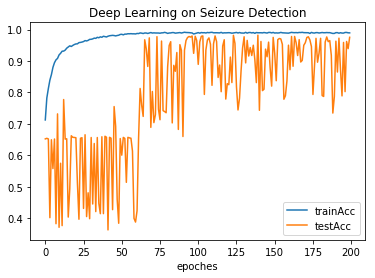

In [12]:
import matplotlib.pyplot as plt
x = range(0, epoches)

plt.plot(x, trainAcc, label='trainAcc')
# plt.plot(x, trainLoss, label='trainLoss')
plt.plot(x, testAcc, label='testAcc')

plt.xlabel('epoches')

plt.title("Deep Learning on Seizure Detection")

plt.legend()

plt.show()

In [14]:
len(fileName)

12852